In [1]:
import numpy as np
import pandas as pd
from mpl_toolkits.basemap import Basemap # Import the Basemap toolkit
import matplotlib.pyplot as plt
import datetime
import utils
from matplotlib.colors import from_levels_and_colors
import seaborn as sns

In [18]:
from datetime import datetime

In [ ]:
datetime_now =datetime.datetime.utcnow()

time, snow = utils.get_snow_data(datetime_now)
# Snow is shape (6, 909, 671), previous 6 hours

lons, lats = utils.get_coords()

In [29]:
run = utils.get_run(datetime_now)
filename = 'sn_vzp%s_obdn%s.asc.zip' % (datetime_now.strftime(
    '%Y%m%d') + run, datetime_now.strftime('%y%m%d') + run)

widths = np.full(671, 7, dtype=int).tolist()
df = pd.read_fwf(utils.base_url + filename, skiprows=[0, 911, 1822, 2733, 3644, 4555],
                    widths=widths, header=None, lineterminator='\n', na_values=-99.9, compression='zip')

date_end_file = filename[21:29]
time = pd.date_range(end=datetime.strptime(
    date_end_file, '%y%m%d%H'), freq='1h', periods=6)

chunks = utils.split(df, 910)
snow = np.empty(shape=(0, 910, 671), dtype=float)
for c in chunks:
    if c.values.shape[0] != 0:
        snow = np.append(snow, [c.values], axis=0)
snow = np.ma.masked_invalid(snow)
snow = np.ma.masked_less_equal(snow, 1)

/home/ekman/miniconda3/lib/python3.8/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))
/home/ekman/miniconda3/lib/python3.8/site-packages/pyproj/crs/crs.py:294: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  projstring = _prepare_from_string(" ".join((projstring, projkwargs)))


http://server.arcgisonline.com/ArcGIS/rest/services/World_Shaded_Relief/MapServer/export?bbox=5.3772,47.1597,15.6116,55.0632&bboxSR=4326&imageSR=4326&size=500,386&dpi=96&format=png32&transparent=true&f=image


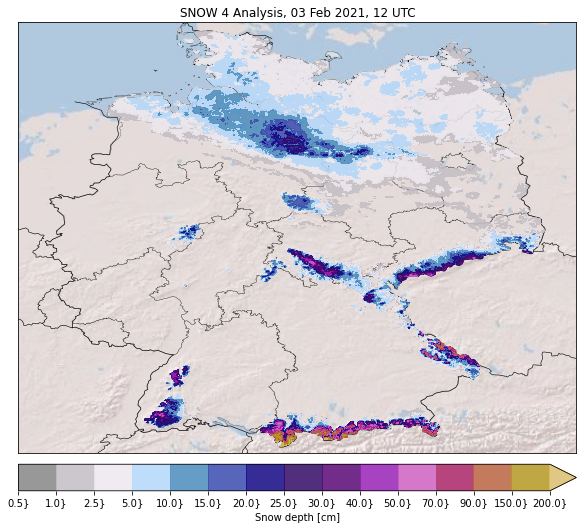

In [27]:
fig = plt.figure(figsize=(10,10))

m = Basemap(projection='cyl', llcrnrlon=lons.min(), llcrnrlat=lats.min(),\
               urcrnrlon=lons.max(), urcrnrlat=lats.max(),  resolution='i')
x, y = m(lons,lats)

levels_snow = (0.5, 1, 2.5, 5, 10, 15, 20, 25, 30, 40, 50, 70, 90, 150, 200)

colors_tuple = pd.read_csv('cmap_snow_wxcharts.rgba', header=None).values    
cmap_snow, norm_snow = from_levels_and_colors(levels_snow,
                       sns.color_palette(colors_tuple, n_colors=len(levels_snow)),
                 extend='max')

img=m.arcgisimage(service='World_Shaded_Relief', xpixels = 500, verbose= True)
img.set_alpha(0.8)
m.drawcountries(linewidth=0.6, linestyle='solid', color='black')
m.readshapefile('shapefiles/DEU_adm/DEU_adm1','DEU_adm1',
                linewidth=0.2,color='black')

cs = m.contourf(x, y, snow[-1,:,:], levels=levels_snow, cmap=cmap_snow, norm=norm_snow, extend='max',
                alpha=0.85, zorder=4)

plt.colorbar(orientation='horizontal', label='Snow depth [cm]',
             pad=0.02, fraction=0.05, ticks=levels_snow, format='%.1f}')
plt.title('SNOW 4 Analysis, '+time[-1].strftime('%d %b %Y, %H UTC'))
#plt.savefig('hsnow.png', dpi=150, bbox_inches='tight')
plt.show()